In [1]:
def read_data(filename):
    """ Read raw data to array """
    res = []
  
    with open(filename, 'r') as f:
        data_started = False
        for cnt, line in enumerate(f):
            if not data_started and "#DATA BEGINS" in line:
                data_started = True
            elif data_started:
                res.append(line.split("	"))

    return res

def get_cycles(values):
    """ Convert raw measurements to the list of cycles, each cycle
    contains measurements from all source-detector channels """
    
    record = -1
    cycle = {}
    res = []
    
    for i, row in enumerate(values):
        if len(row) < 16:
            break
            
        source = {
            'record': row[0],
            'source': row[1],
        }
        
        for detector in range(14):
            idx = 2 + detector * 3
            letter = chr(ord('A') + detector)
            source[letter] = {
                'ac': float(row[idx]),
                'dc': float(row[idx+1]),
                'ph': float(row[idx+2])
            }
            
        source['time'] = row[2 + 14 * 3]
        
        cycle[int(row[1])] = source
        
        if row[1] == '32':
            res.append(cycle)
            cycle = {}
        
    return res

In [2]:
# Read raw data from the file and convert to the list of cycles
values = read_data('Data_20180608_042159.txt')
cycles = get_cycles(values[2:])

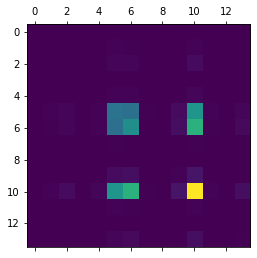

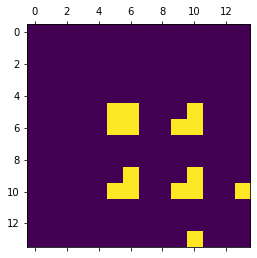

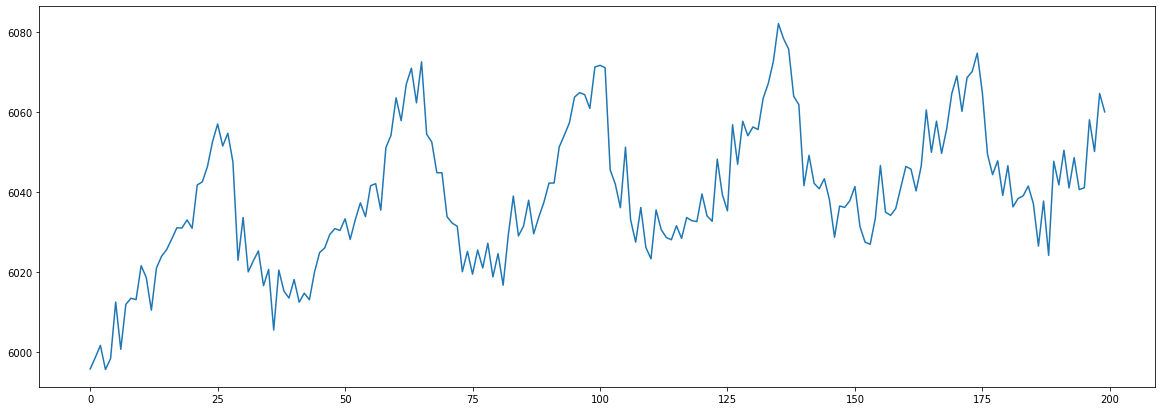

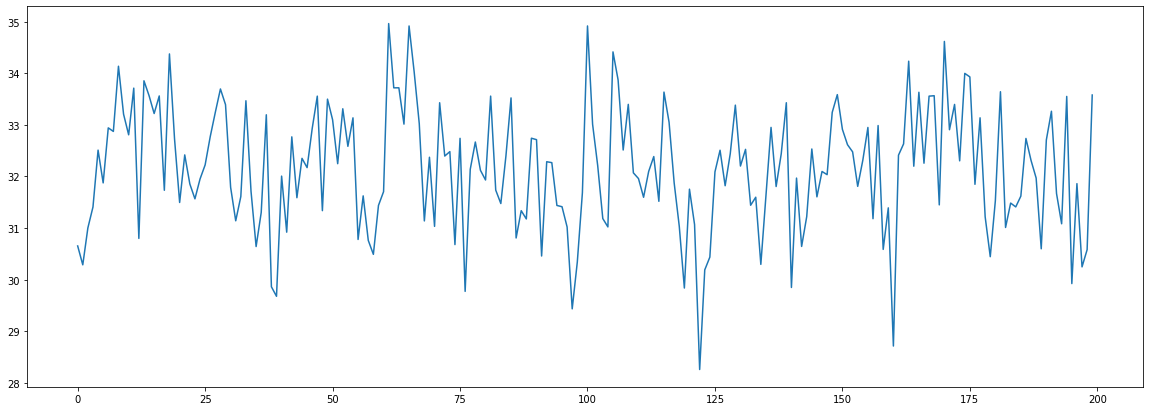

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# List of detector letters
letters = [chr(ord('A') + x) for x in range(14)]

# select source for covariance
source = 8
batch = []

# add first 200 measurements to the batch
for l in letters:
    batch.append(np.array([x[source][l]['ac'] for x in cycles[0:200]]))

# calculate covariance and thresholded covariance
corr = np.cov(batch)
plt.matshow(np.abs(corr))
plt.matshow(np.abs(corr > 15))

# extract AC data for source 5 and detectors B and A
a1_ac = np.array([x[5]['B']['ac'] for x in cycles[0:200]])
b2_ac = np.array([x[5]['A']['ac'] for x in cycles[0:200]])

plt.figure(figsize=(20,7))
plt.plot(a1_ac)
plt.show()
plt.figure(figsize=(20,7))
plt.plot(b2_ac)
plt.show()

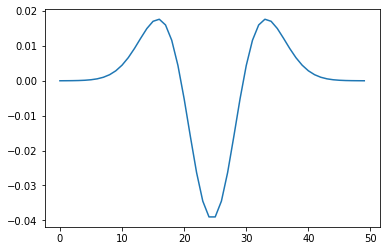

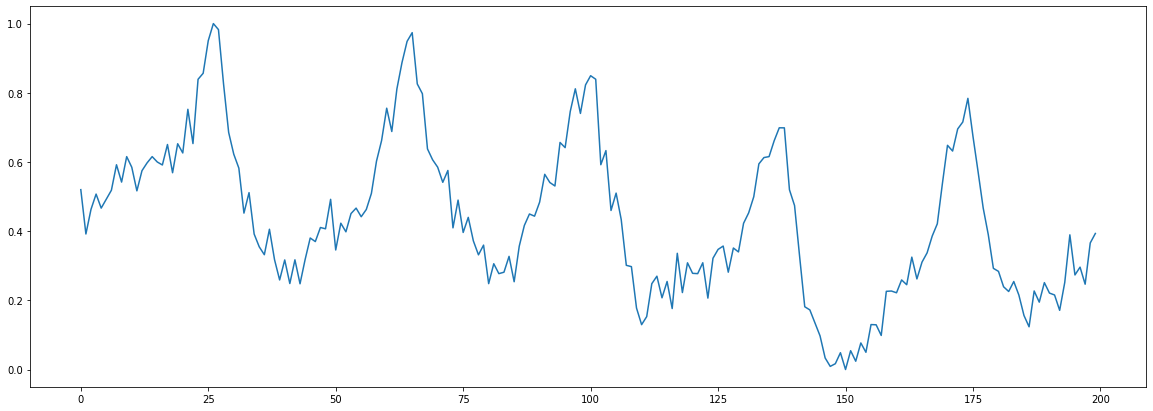

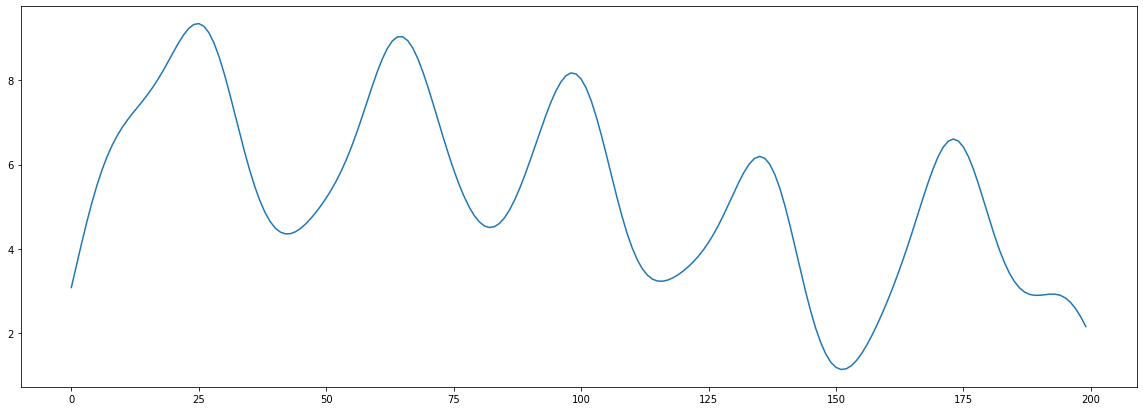

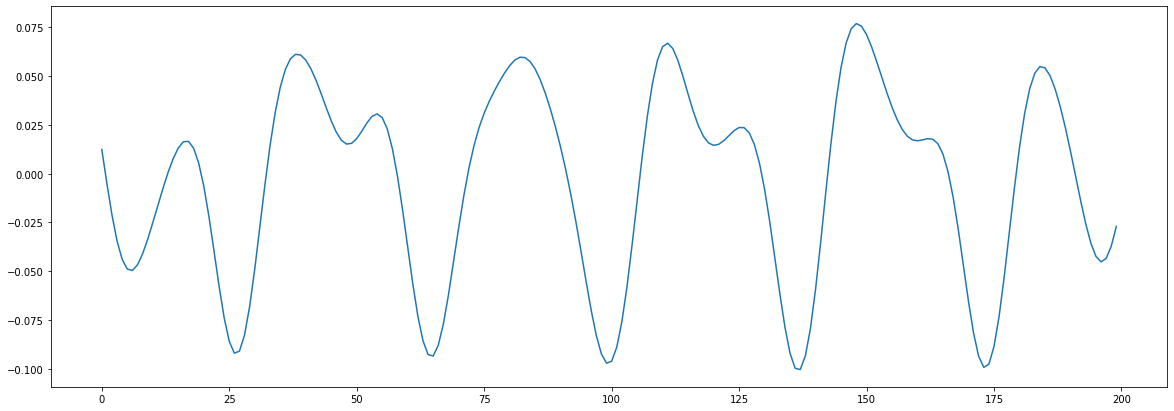

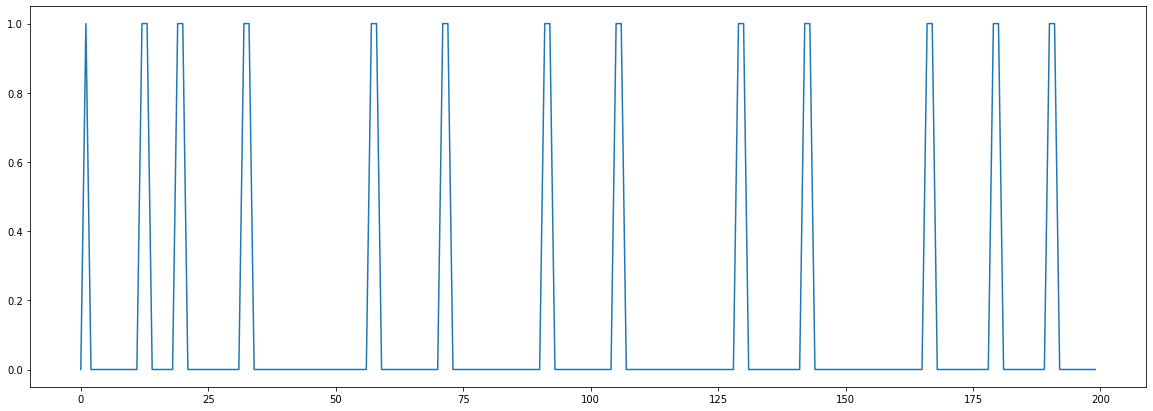

In [14]:
from scipy import signal, ndimage
import cv2 as cv

# Create gaussian 
window = signal.gaussian(50, std=5)

# Convlve gaussian with laplace operator
log = signal.convolve(window, [1, -2, 1], 'same')

# Show operator
plt.plot(log)
plt.show()

raw = []
gauss_conv = []
log_conv = []
edges = []

# Collect AC data from all channels from the first 200 cycles
for l in letters:
    for s in range(32):
        ac = np.array([x[s+1][l]['ac'] for x in cycles[0:200]])
        
        # Normalize values to the range 0-1
        high = ac.max()
        low = ac.min()
        ac = (ac - low) / (high - low)
        ac_log = signal.convolve(ac, log, 'same')
        ac_gauss = signal.convolve(ac, window, 'same')
        zcross = np.zeros(ac_log.shape)
        
        # Perform zero-crossing
        t = 0.0001
        for i, x in enumerate(ac_log, 1):
            if ac_log[i-1] < -t and (len(ac_log) > i+1) and ac_log[i+1] > t:
                zcross[i] = 1
            elif ac_log[i-1] > t and (len(ac_log) > i+1) and ac_log[i+1] < -t:
                zcross[i] = 1
            
        raw.append(ac)
        log_conv.append(ac_log)
        gauss_conv.append(ac_gauss)
        edges.append(zcross)


def show_plots(index):
    """ Display plots: raw, gaussian smoothing, laplacian of gaussian, and detected edges """
    plt.figure(figsize=(20,7))
    plt.plot(raw[index])
    plt.show()
                
    plt.figure(figsize=(20,7))
    plt.plot(gauss_conv[index])
    plt.show()
        
    plt.figure(figsize=(20,7))
    plt.plot(log_conv[index])
    plt.show()
        
    plt.figure(figsize=(20,7))
    plt.plot(edges[index])
    plt.show()
        
        
show_plots(3)

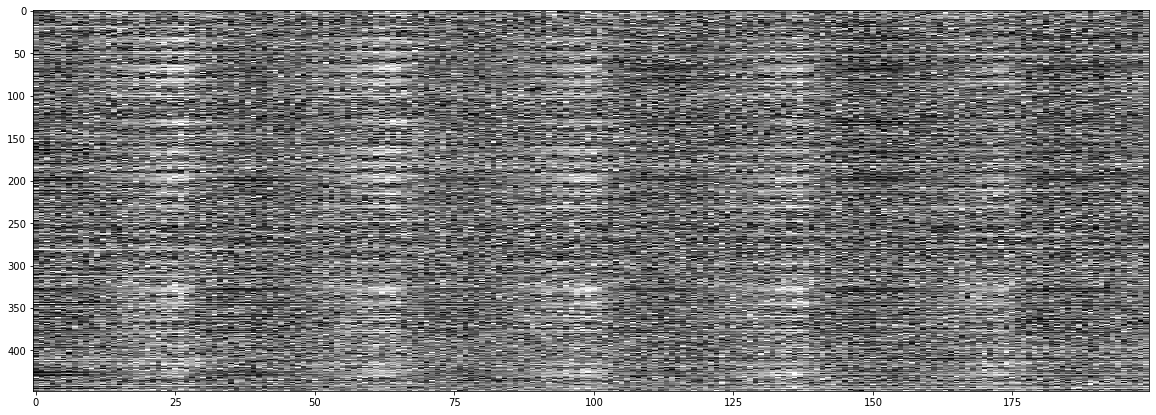

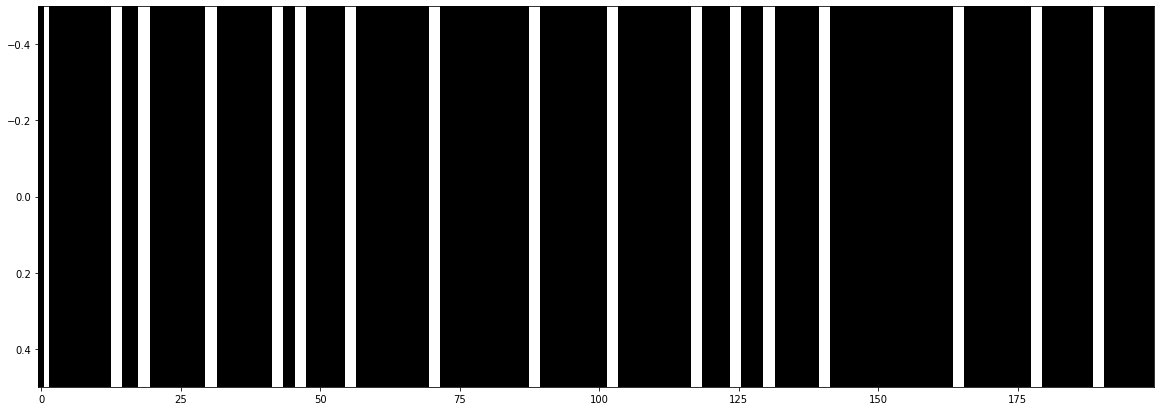

In [15]:
# Show picture of a single signal with detected edges

plt.figure(figsize=(20,7))
plt.imshow(raw, aspect='auto', cmap="gray")
plt.show()

plt.figure(figsize=(20,7))
plt.imshow(edges[:1], aspect='auto', cmap="gray")
plt.show()